In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd 'drive/My Drive/Siamese/Encoder/Freq'

/content/drive/My Drive/Siamese/Encoder/Freq


In [4]:
import sys
sys.path.insert(0, '../../Data')
sys.path.insert(0, '../..')
sys.path.insert(0, '..')

In [5]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 3.9MB/s 


In [6]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [7]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 50

torch.backends.cudnn.deterministic = True
B = 64

WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
NUM_WORKERS = 4

NUM_CLASSES = 200

In [8]:
from Normalize import Normalize
from ToTensor import ToTensor
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

trainset = IdentificationDataset(DATASET_PATH, 
                                 NUM_CLASSES,
                                 train=True, 
                                 transform=transforms,
                                 lenght=2,
                                 return_type=ReturnType.ENCODER)
trainsetloader = torch.utils.data.DataLoader(trainset, 
                                             batch_size=B, 
                                             num_workers=NUM_WORKERS, 
                                             shuffle=True)

testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=2,
                                return_type=ReturnType.ENCODER)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=4, 
                                            num_workers=NUM_WORKERS)

print("lenght train loader ", len(trainsetloader))
print("lenght test loader ", len(testsetloader))


sample lenght  2
sample lenght  2
lenght train loader  371
lenght test loader  534


In [ ]:
from TransFourier import TransFourier

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
net = TransFourier()
net.to(DEVICE)

cuda


TransFourier(
  (spectrogram): Spectrogram()
  (amp): AmplitudeToDB()
  (block1): Conv2DBlock(
    (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Conv2DBlock(
    (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Conv2DBlock(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
    (conv2): Conv2d(256, 192, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1

In [ ]:
import numpy as np
optimizer = optim.SGD(net.parameters(), LR_INIT, MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

max_accuracy = 0
test_accuracy = []
train_accuracy = []

train_loss = 0
train_losses = []
test_loss = 0
test_losses = []

for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    lr_scheduler.step()
    
    # train
    print("*** Train ***")
    net.train()

    accuracy = 0
    nb_test = 0
    
    for iter_num, (_, a, p, n_label, n) in tqdm(enumerate(trainsetloader)):
        optimizer.zero_grad()
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)

        loss, results, a, p, n = net(a, p , n)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1

    train_accuracy.append(accuracy/nb_test)
    train_loss /= len(trainsetloader)
    train_losses.append(train_loss)

    # test
    net.eval()
    print("*** Test ***")
    
    accuracy = 0
    nb_test = 0
    loss = 0

    for iter_num, (label, a, p, n_label, n) in tqdm(enumerate(testsetloader)):
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        loss, results, a, p, n = net(a, p , n)

        # Calculate loss
        test_loss += loss.item()

        for result in results:
          nb_test += 1
          if result == True:
            accuracy += 1
    
    accuracy /= nb_test
    test_accuracy.append(accuracy)
    print("accuracy = ", accuracy)
    if accuracy > max_accuracy:
      net.store_encoder(1)
      max_accuracy = accuracy
    test_loss /= len(testsetloader)
    test_losses.append(test_loss)


*** Epoch  0  ***
*** Train ***


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
371it [1:10:30, 11.40s/it]

*** Test ***



534it [06:20,  1.41it/s]

accuracy =  0.7703842549203374
*** Epoch  1  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.88it/s]


accuracy =  0.7933458294283037
*** Epoch  2  ***
*** Train ***


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.06it/s]


accuracy =  0.7877225866916588
*** Epoch  3  ***
*** Train ***


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.38it/s]

accuracy =  0.8013120899718837
*** Epoch  4  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.98it/s]

accuracy =  0.816776007497657
*** Epoch  5  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.32it/s]


accuracy =  0.8191190253045924
*** Epoch  6  ***
*** Train ***


371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 60.25it/s]

accuracy =  0.8177132146204311
*** Epoch  7  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.20it/s]

accuracy =  0.8181818181818182
*** Epoch  8  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.75it/s]

accuracy =  0.8247422680412371
*** Epoch  9  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.36it/s]

accuracy =  0.8364573570759137
*** Epoch  10  ***
*** Train ***



371it [02:23,  2.58it/s]

*** Test ***



534it [00:08, 60.46it/s]

accuracy =  0.8345829428303655
*** Epoch  11  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 60.44it/s]

accuracy =  0.8355201499531396
*** Epoch  12  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 60.67it/s]

accuracy =  0.8289597000937207
*** Epoch  13  ***
*** Train ***



52it [00:20,  2.59it/s]

Error in Normalize 0.0


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.21it/s]

accuracy =  0.8247422680412371
*** Epoch  14  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.99it/s]

accuracy =  0.8364573570759137
*** Epoch  15  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.00it/s]


accuracy =  0.8411433926897844
*** Epoch  16  ***
*** Train ***


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.90it/s]

accuracy =  0.8397375820056232
*** Epoch  17  ***
*** Train ***



186it [01:12,  2.59it/s]

Error in Normalize 0.0


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.91it/s]

accuracy =  0.8388003748828491
*** Epoch  18  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.53it/s]


accuracy =  0.8425492033739457
*** Epoch  19  ***
*** Train ***


371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 60.04it/s]


accuracy =  0.8439550140581068
*** Epoch  20  ***
*** Train ***


371it [02:24,  2.58it/s]

*** Test ***



534it [00:09, 59.23it/s]

accuracy =  0.8458294283036552
*** Epoch  21  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.94it/s]

accuracy =  0.8486410496719775
*** Epoch  22  ***
*** Train ***



371it [02:23,  2.58it/s]

*** Test ***



534it [00:08, 60.13it/s]

accuracy =  0.8477038425492034
*** Epoch  23  ***
*** Train ***



371it [02:23,  2.58it/s]

*** Test ***



534it [00:08, 60.02it/s]


accuracy =  0.8444236176194939
*** Epoch  24  ***
*** Train ***


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.75it/s]

accuracy =  0.8495782567947516
*** Epoch  25  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.82it/s]


accuracy =  0.8472352389878163
*** Epoch  26  ***
*** Train ***


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.95it/s]

accuracy =  0.851921274601687
*** Epoch  27  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.92it/s]

accuracy =  0.8477038425492034
*** Epoch  28  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.43it/s]

accuracy =  0.8547328959700093
*** Epoch  29  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.17it/s]


accuracy =  0.8486410496719775
*** Epoch  30  ***
*** Train ***


371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.88it/s]

accuracy =  0.8528584817244611
*** Epoch  31  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.06it/s]

accuracy =  0.8505154639175257
*** Epoch  32  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 60.25it/s]

accuracy =  0.8631677600749765
*** Epoch  33  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.13it/s]

accuracy =  0.8533270852858482
*** Epoch  34  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 60.25it/s]


accuracy =  0.852389878163074
*** Epoch  35  ***
*** Train ***


371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 60.25it/s]

accuracy =  0.851921274601687
*** Epoch  36  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.99it/s]

accuracy =  0.8547328959700093
*** Epoch  37  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.31it/s]

accuracy =  0.8561387066541706
*** Epoch  38  ***
*** Train ***



299it [01:56,  2.58it/s]

Error in Normalize 0.0


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.09it/s]

accuracy =  0.8603561387066542
*** Epoch  39  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.91it/s]

accuracy =  0.8552014995313965
*** Epoch  40  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.88it/s]


accuracy =  0.8603561387066542
*** Epoch  41  ***
*** Train ***


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.10it/s]

accuracy =  0.8561387066541706
*** Epoch  42  ***
*** Train ***



371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 59.86it/s]

accuracy =  0.8566073102155577
*** Epoch  43  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:09, 59.32it/s]

accuracy =  0.8556701030927835
*** Epoch  44  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.70it/s]

accuracy =  0.8580131208997188
*** Epoch  45  ***
*** Train ***



371it [02:24,  2.58it/s]

*** Test ***



534it [00:09, 58.28it/s]

accuracy =  0.8542642924086223
*** Epoch  46  ***
*** Train ***



305it [01:58,  2.59it/s]

Error in Normalize 0.0


371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.93it/s]

accuracy =  0.8556701030927835
*** Epoch  47  ***
*** Train ***



371it [02:23,  2.58it/s]

*** Test ***



534it [00:09, 58.50it/s]


accuracy =  0.8580131208997188
*** Epoch  48  ***
*** Train ***


371it [02:24,  2.57it/s]

*** Test ***



534it [00:08, 60.52it/s]


accuracy =  0.8570759137769447
*** Epoch  49  ***
*** Train ***


371it [02:24,  2.58it/s]

*** Test ***



534it [00:08, 59.41it/s]

accuracy =  0.8598875351452671


train accuracy end:0.92 max:0.923
test accuracy end:0.86 max:0.863


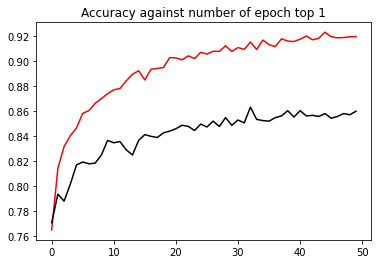

In [ ]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], train_accuracy , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_accuracy , label='test 1', color='black')
print('train accuracy end:{} max:{}'
.format(round(train_accuracy[EPOCH_NUM-1], 3), round(np.max(train_accuracy), 3)))
print('test accuracy end:{} max:{}'
.format(round(test_accuracy[EPOCH_NUM-1], 3), round(np.max(test_accuracy), 3)))


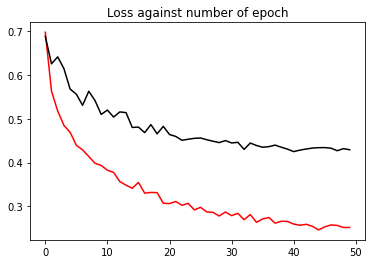

In [ ]:
plt.title("Loss against number of epoch")
plt.plot([i for i in range(EPOCH_NUM)], train_losses , label='Train loss', color='red')
plt.plot([i for i in range(EPOCH_NUM)], test_losses , label='Test loss', color='black')
